# Quick start

In [1]:
# @title Install AlphaGenome

# @markdown 运行以安装模型
from IPython.display import clear_output
! pip install alphagenome
clear_output()

## 导入相关的包

In [2]:
from alphagenome import colab_utils
from alphagenome.data import gene_annotation
from alphagenome.data import genome
from alphagenome.data import transcript as transcript_utils
from alphagenome.interpretation import ism
from alphagenome.models import dna_client
from alphagenome.models import variant_scorers
from alphagenome.visualization import plot_components
import matplotlib.pyplot as plt
import pandas as pd

## 根据DNA序列进行预测

In [3]:
dna_model = dna_client.create(colab_utils.get_api_key())

模型可以预测的类型[output types](https://www.alphagenomedocs.com/exploring_model_metadata.html):

In [4]:
[output.name for output in dna_client.OutputType]

['ATAC',
 'CAGE',
 'DNASE',
 'RNA_SEQ',
 'CHIP_HISTONE',
 'CHIP_TF',
 'SPLICE_SITES',
 'SPLICE_SITE_USAGE',
 'SPLICE_JUNCTIONS',
 'CONTACT_MAPS',
 'PROCAP']

AlphaGenome可以预测每个输出类型的多个“轨迹”，覆盖各种组织和细胞类型。可以有效地对感兴趣的子集进行预测。

以下是如何在对应于肺组织的轨迹子集中（由ontology_terms指定）为长度为2048的短DNA序列进行DNase-seq预测（由OutputType指定）：

这里展示了三个类型的预测结果ATAC,RNA_seq，DNAse

In [ ]:
以下结果均以nonzero_mean作为预测得分

In [18]:
output = dna_model.predict_sequence(
    sequence='GATTACA'.center(2048, 'N'),  # Pad to valid sequence length.
    requested_outputs=[dna_client.OutputType.DNASE,
              dna_client.OutputType.ATAC,
              dna_client.OutputType.RNA_SEQ],
    ontology_terms=['UBERON:0002048'],  # 肺
)
dnase_values = output.dnase.values
ATAC_values = output.atac.values
RNA_values = output.rna_seq.values

In [28]:
#输出DNA的开放性与可及性
dnase=output.dnase
dnase.metadata


,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,biosample_life_stage,data_source,endedness,genetically_modified,nonzero_mean
0,UBERON:0002048 DNase-seq,.,DNase-seq,UBERON:0002048,lung,tissue,embryonic,encode,paired,False,0.427505


In [29]:
#预测染色质可及性
atac=output.atac
atac.metadata

,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,biosample_life_stage,data_source,endedness,genetically_modified,nonzero_mean
0,UBERON:0002048 ATAC-seq,.,ATAC-seq,UBERON:0002048,lung,tissue,adult,encode,paired,False,2.980637


In [30]:
#预测转录活性
rna_seq=output.rna_seq
rna_seq.metadata

,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,biosample_life_stage,gtex_tissue,data_source,endedness,genetically_modified,nonzero_mean
0,UBERON:0002048 polyA plus RNA-seq,+,polyA plus RNA-seq,UBERON:0002048,lung,tissue,adult,,encode,paired,False,0.119172
1,UBERON:0002048 total RNA-seq,+,total RNA-seq,UBERON:0002048,lung,tissue,embryonic,,encode,paired,False,0.081345
2,UBERON:0002048 polyA plus RNA-seq,-,polyA plus RNA-seq,UBERON:0002048,lung,tissue,adult,,encode,paired,False,0.119172
3,UBERON:0002048 total RNA-seq,-,total RNA-seq,UBERON:0002048,lung,tissue,embryonic,,encode,paired,False,0.081345


## 基因组区间分析



我们首先加载一个包含基因和转录本位置的 GTF 文件，该文件由 GENCODE 注释

In [31]:
gtf = pd.read_feather(
    'https://storage.googleapis.com/alphagenome/reference/gencode/'
    'hg38/gencode.v46.annotation.gtf.gz.feather'
)

gtf_transcripts = gene_annotation.filter_protein_coding(gtf)
gtf_transcripts = gene_annotation.filter_to_longest_transcript(gtf_transcripts)
transcript_extractor = transcript_utils.TranscriptExtractor(gtf_transcripts)

然后通过传递基因的 `gene_symbol`（HGNC 命名规范）或 ENSEMBL `gene_id`，以 `genome.Interval` 对象的形式获取基因的位置：

In [32]:
interval = gene_annotation.get_gene_interval(gtf, gene_symbol='CYP2B6')
interval

Interval(chromosome='chr19', start=40991281, end=41018398, strand='+', name='CYP2B6')

我们可以将其调整为与模型兼容的长度：

In [33]:
interval = interval.resize(dna_client.SEQUENCE_LENGTH_1MB)

`.resize()` 方法通过围绕其原始中心扩展（或收缩）来将区间调整为指定的宽度。请注意，`dna_model.predict_interval()` 将此调整大小解释为实际基因组序列的扩展，而不是填充 tokens。


In [34]:
interval.width

1048576

 Alphagenome可以使用五个大小的基因组长度，2kb,16kb,100kb,500kb,1mb

In [ ]:
dna_client.SUPPORTED_SEQUENCE_LENGTHS.keys()

dict_keys(['SEQUENCE_LENGTH_2KB', 'SEQUENCE_LENGTH_16KB', 'SEQUENCE_LENGTH_100KB', 'SEQUENCE_LENGTH_500KB', 'SEQUENCE_LENGTH_1MB'])

使用基因组序列进行预测

In [35]:
output = dna_model.predict_interval(
    interval=interval,
    requested_outputs=[dna_client.OutputType.RNA_SEQ],
    ontology_terms=['UBERON:0001114'],
)  # Right liver lobe.

output.rna_seq.values.shape

(1048576, 3)

通常，对于给定的本体术语，您可以有多个track。 在这种情况下，我们有3个RNA-seq track用于“右肝叶”组织。

可视化这些预测。

In [36]:
longest_transcripts = transcript_extractor.extract(interval)
print(f'Extracted {len(longest_transcripts)} transcripts in this interval.')

Extracted 29 transcripts in this interval.


我们还提供了一个[可视化基础指南](https://www.alphagenomedocs.com/visualization_library_basics.html)，它可以与`TrackData`以及模型API返回的其他对象完美集成。

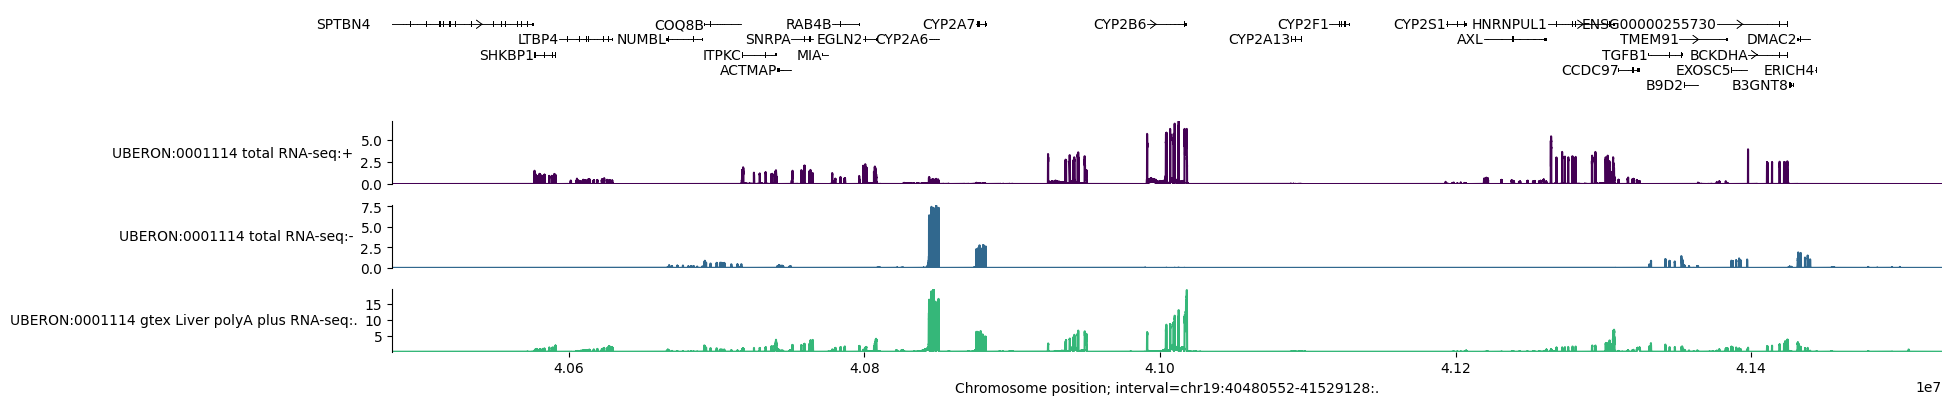

In [37]:
plot_components.plot(
    components=[
        plot_components.TranscriptAnnotation(longest_transcripts),
        plot_components.Tracks(output.rna_seq),
    ],
    interval=output.rna_seq.interval,
)

plt.show()

此图可视化了 3 个预测的 RNA-seq 轨道，并标记了每个基因在 1MB 区域中最长转录本的位置。

我们可以通过调整区间大小来放大到绘图的中间部分：

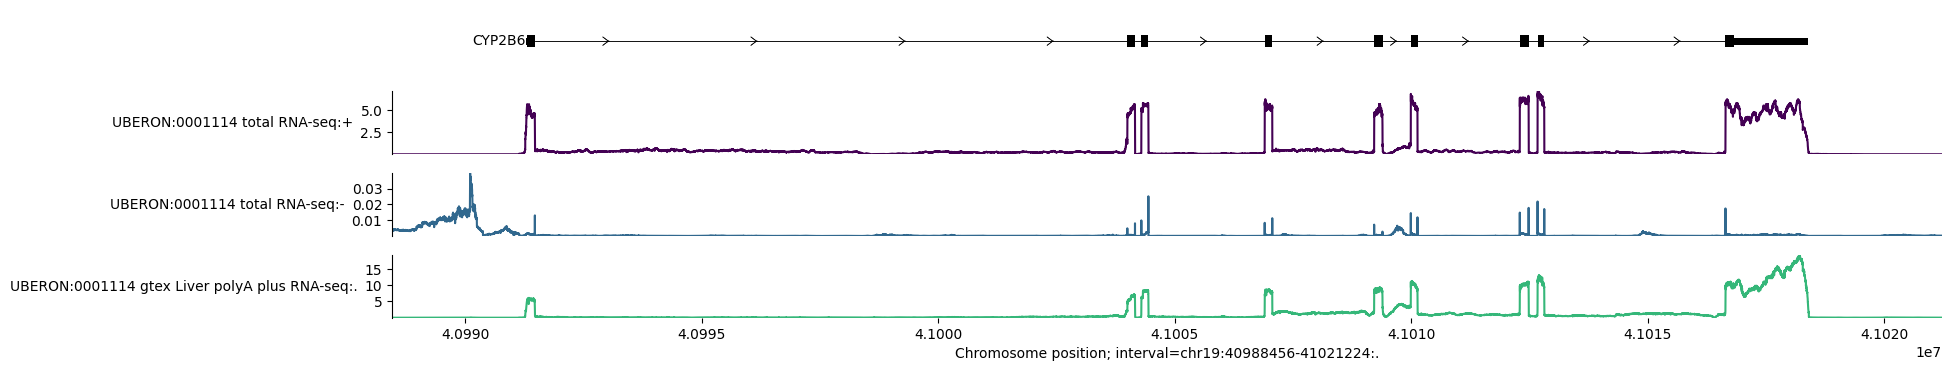

In [38]:
plot_components.plot(
    components=[
        plot_components.TranscriptAnnotation(
            longest_transcripts, fig_height=0.1
        ),
        plot_components.Tracks(output.rna_seq),
    ],
    interval=output.rna_seq.interval.resize(2**15),
)

plt.show()

在此处可以看到，预测的 RNA-seq 值与外显子的位置很好地对齐，并且预测是链特异性的 – 对于正链，预测值要高得多，基因就位于正链上。我们看到 *CYP2B6* 基因位于正链上，因为转录本中的箭头从左向右。


## 预测变异影响



我们可以通过预测参考 (REF) 和替代 (ALT) 等位基因序列，来预测某个变异对特定输出类型和组织的影响。

我们通过定义一个 `genome.Variant` 对象来指定变异。下面的特定变异是一个已知的影响结肠组织中基因表达的变异：

In [39]:
variant = genome.Variant(
    chromosome='chr22',
    position=36201698,
    reference_bases='A',  # Can differ from the true reference genome base.
    alternate_bases='C',
)

接下来，我们定义进行REF和ALT预测的区间。从`genome.Variant`获取`genome.Interval`的一个快捷方法是调用`.reference_interval`，我们可以将其调整为模型兼容的序列长度：

In [ ]:
interval = variant.reference_interval.resize(dna_client.SEQUENCE_LENGTH_1MB)

然后，我们使用`predict_variant`来获取“结肠 - 横结肠”组织（`UBERON:0001157`）的REF和ALT RNA-seq预测结果。

In [ ]:
variant_output = dna_model.predict_variant(
    interval=interval,
    variant=variant,
    requested_outputs=[dna_client.OutputType.RNA_SEQ],
    ontology_terms=['UBERON:0001157'],
)  # Colon - Transverse.

我们可以将预测的REF和ALT值绘制成单个图表，并放大受影响的基因，以更好地可视化变异对基因表达的影响：

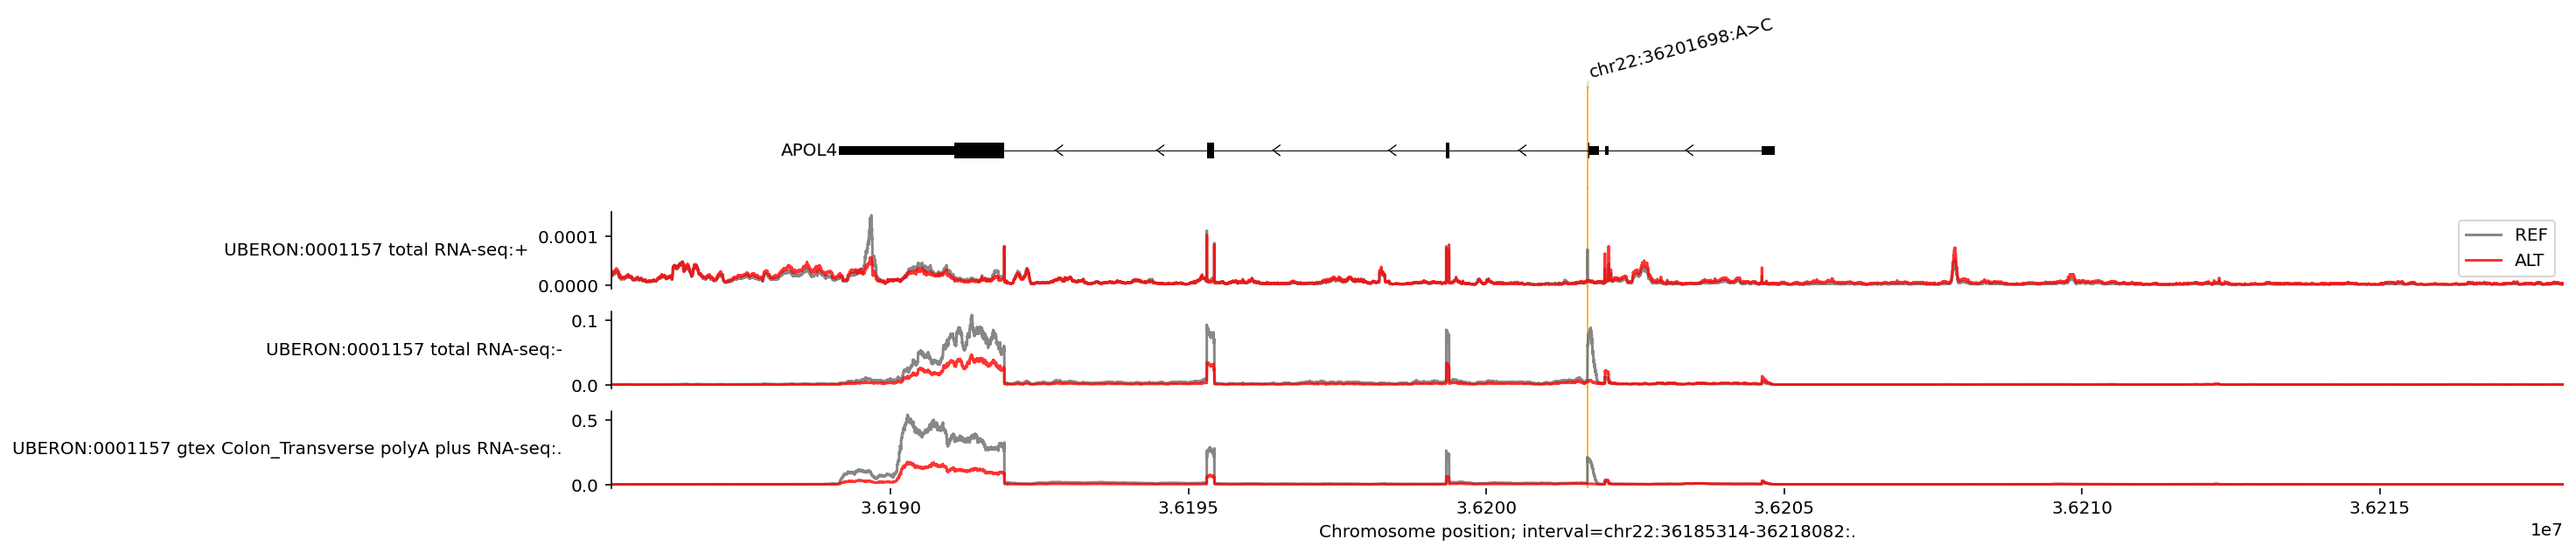

In [ ]:
longest_transcripts = transcript_extractor.extract(interval)

plot_components.plot(
    [
        plot_components.TranscriptAnnotation(longest_transcripts),
        plot_components.OverlaidTracks(
            tdata={
                'REF': variant_output.reference.rna_seq,
                'ALT': variant_output.alternate.rna_seq,
            },
            colors={'REF': 'dimgrey', 'ALT': 'red'},
        ),
    ],
    interval=variant_output.reference.rna_seq.interval.resize(2**15),
    # Annotate the location of the variant as a vertical line.
    annotations=[plot_components.VariantAnnotation([variant], alpha=0.8)],
)
plt.show()

我们发现，ALT等位基因（位置36201698处的碱基'C'）与负链上*APOL4*基因的较低表达和外显子跳跃事件相关。请注意，我们可以忽略最上面的线图，因为它显示了正向DNA链上非常小的预测表达量（检查y轴刻度）。可以调整y轴的限制，


## 对基因变异的影响进行评分

对基因变异的影响进行评分涉及对 REF 和 ALT 序列进行预测，并聚合 track 信号。这在 `score_variant` 中实现，它使用特定的 `variant_scorer` 配置进行聚合。

我们提供了一组推荐的变异评分配置，以字典形式存在（`variant_scorers.RECOMMENDED_VARIANT_SCORERS`），涵盖所有输出类型，并且我们已经评估了它们在特定领域任务中的性能。

In [ ]:
variant_scorer = variant_scorers.RECOMMENDED_VARIANT_SCORERS['RNA_SEQ']

variant_scores = dna_model.score_variant(
    interval=interval, variant=variant, variant_scorers=[variant_scorer]
)

每个变体的实际得分采用 `AnnData` 格式，这是一种使用关于行和列的附加信息来注释数据（数值得分）的方式。

In [ ]:
variant_scores = variant_scores[0]
variant_scores

AnnData object with n_obs × n_vars = 37 × 667
    obs: 'gene_id', 'strand', 'gene_name', 'gene_type'
    var: 'name', 'strand', 'Assay title', 'ontology_curie', 'biosample_name', 'biosample_type', 'biosample_life_stage', 'gtex_tissue', 'data_source', 'endedness', 'genetically_modified', 'nonzero_mean'
    uns: 'interval', 'variant', 'variant_scorer'
    layers: 'quantiles'

我们可以使用 `.obs` 访问有关这 37 个基因的信息。以下是前 5 个基因：

In [ ]:
variant_scores.obs.head()

,gene_id,strand,gene_name,gene_type
0,ENSG00000100320.24,-,RBFOX2,protein_coding
1,ENSG00000100336.18,-,APOL4,protein_coding
2,ENSG00000100342.22,+,APOL1,protein_coding
3,ENSG00000100345.23,-,MYH9,protein_coding
4,ENSG00000100348.10,-,TXN2,protein_coding


请注意，如果您使用的变异位点评分器不是基因特异性的（例如，`variant_scorers.CenterMaskScorer`），那么 `variant_scores.X` 的形状将为 `(1, 667)`，并且由于在这种情况下没有基因的概念，因此不会有基因元数据可用。

每个 track 的描述都使用 `.var` 访问（这与输出元数据的 dataframe 相同，但为了方便起见，与变异位点评分一起包含）：

In [ ]:
variant_scores.var

,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,biosample_life_stage,gtex_tissue,data_source,endedness,genetically_modified,nonzero_mean
0,CL:0000047 polyA plus RNA-seq,+,polyA plus RNA-seq,CL:0000047,neuronal stem cell,in_vitro_differentiated_cells,embryonic,,encode,paired,False,0.143617
1,CL:0000062 total RNA-seq,+,total RNA-seq,CL:0000062,osteoblast,primary_cell,adult,,encode,paired,False,0.094144
2,CL:0000084 polyA plus RNA-seq,+,polyA plus RNA-seq,CL:0000084,T-cell,primary_cell,adult,,encode,paired,False,0.124296
3,CL:0000084 total RNA-seq,+,total RNA-seq,CL:0000084,T-cell,primary_cell,adult,,encode,single,False,0.100934
4,CL:0000115 total RNA-seq,+,total RNA-seq,CL:0000115,endothelial cell,in_vitro_differentiated_cells,adult,,encode,single,False,0.135553
...,...,...,...,...,...,...,...,...,...,...,...,...
662,UBERON:0018115 polyA plus RNA-seq,.,polyA plus RNA-seq,UBERON:0018115,left renal pelvis,tissue,embryonic,,encode,single,False,0.268222
663,UBERON:0018116 polyA plus RNA-seq,.,polyA plus RNA-seq,UBERON:0018116,right renal pelvis,tissue,embryonic,,encode,single,False,0.258522
664,UBERON:0018117 polyA plus RNA-seq,.,polyA plus RNA-seq,UBERON:0018117,left renal cortex interstitium,tissue,embryonic,,encode,single,False,0.215190
665,UBERON:0018118 polyA plus RNA-seq,.,polyA plus RNA-seq,UBERON:0018118,right renal cortex interstitium,tissue,embryonic,,encode,single,False,0.365676


一些方便的附加元数据可以在 `.uns` 中找到：

In [ ]:
print(f'Interval: {variant_scores.uns["interval"]}')
print(f'Variant: {variant_scores.uns["variant"]}')
print(f'Variant scorer: {variant_scores.uns["variant_scorer"]}')

Interval: chr22:35677410-36725986:.
Variant: chr22:36201698:A>C
Variant scorer: GeneMaskLFCScorer(requested_output=RNA_SEQ)


We recommend interacting with variant scores by flattening `AnnData` objects using `tidy_scores`, which produces a dataframe with each row being a single score for each combination of (variant, gene, scorer, ontology). It optionally excludes stranded tracks which do not match the gene’s strand for gene-specific scorer.

The `raw_score` column contains the same values as stored in `variant_scores.X`. The `quantile_score` column is the rank of the `raw_score` in the distribution of scores for a background set of common variants, represented as a quantile probability. This allows for direct comparison across variant scoring strategies that yield scores on different scales. See [FAQs](https://www.alphagenomedocs.com/faqs.html#what-is-the-difference-between-a-quantile-score-and-raw-score) for further details.

In [ ]:

variant_scorers.tidy_scores([variant_scores], match_gene_strand=True)

,variant_id,scored_interval,gene_id,gene_name,gene_type,gene_strand,junction_Start,junction_End,output_type,variant_scorer,track_name,track_strand,Assay title,ontology_curie,biosample_name,biosample_type,gtex_tissue,raw_score,quantile_score
0,chr22:36201698:A>C,chr22:35677410-36725986:.,ENSG00000100320,RBFOX2,protein_coding,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),CL:0000047 polyA plus RNA-seq,-,polyA plus RNA-seq,CL:0000047,neuronal stem cell,in_vitro_differentiated_cells,,0.000903,0.606708
1,chr22:36201698:A>C,chr22:35677410-36725986:.,ENSG00000100320,RBFOX2,protein_coding,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),CL:0000062 total RNA-seq,-,total RNA-seq,CL:0000062,osteoblast,primary_cell,,-0.000363,-0.477020
2,chr22:36201698:A>C,chr22:35677410-36725986:.,ENSG00000100320,RBFOX2,protein_coding,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),CL:0000084 polyA plus RNA-seq,-,polyA plus RNA-seq,CL:0000084,T-cell,primary_cell,,-0.007063,-0.989667
3,chr22:36201698:A>C,chr22:35677410-36725986:.,ENSG00000100320,RBFOX2,protein_coding,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),CL:0000084 total RNA-seq,-,total RNA-seq,CL:0000084,T-cell,primary_cell,,-0.007229,-0.990997
4,chr22:36201698:A>C,chr22:35677410-36725986:.,ENSG00000100320,RBFOX2,protein_coding,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),CL:0000115 total RNA-seq,-,total RNA-seq,CL:0000115,endothelial cell,in_vitro_differentiated_cells,,0.000461,0.449849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14647,chr22:36201698:A>C,chr22:35677410-36725986:.,ENSG00000293594,ENSG00000293594,processed_pseudogene,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),UBERON:0018115 polyA plus RNA-seq,.,polyA plus RNA-seq,UBERON:0018115,left renal pelvis,tissue,,0.006467,0.989427
14648,chr22:36201698:A>C,chr22:35677410-36725986:.,ENSG00000293594,ENSG00000293594,processed_pseudogene,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),UBERON:0018116 polyA plus RNA-seq,.,polyA plus RNA-seq,UBERON:0018116,right renal pelvis,tissue,,0.007303,0.992679
14649,chr22:36201698:A>C,chr22:35677410-36725986:.,ENSG00000293594,ENSG00000293594,processed_pseudogene,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),UBERON:0018117 polyA plus RNA-seq,.,polyA plus RNA-seq,UBERON:0018117,left renal cortex interstitium,tissue,,0.004375,0.964537
14650,chr22:36201698:A>C,chr22:35677410-36725986:.,ENSG00000293594,ENSG00000293594,processed_pseudogene,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),UBERON:0018118 polyA plus RNA-seq,.,polyA plus RNA-seq,UBERON:0018118,right renal cortex interstitium,tissue,,0.003006,0.905090


## Highlighting important regions with *in silico* mutagenesis

To highlight which regions in a DNA sequence are functionally important for a final variant prediction, we can perform an **in silico mutagenesis** (ISM) analysis by scoring all possible single nucleotide variants in a specific interval.

Here is a visual overview of this process:

<a href="https://services.google.com/fh/files/misc/ism_green_v2.png"><img src="https://services.google.com/fh/files/misc/ism_green_v2.png" alt="ISM" border="0" height=500></a>




We define an `ism_interval`, which is a relatively small region of DNA that we want to systematically mutate. We also define the `sequence_interval`, which is the contextual interval the model will use when making predictions for each variant.


In [ ]:
# 2KB DNA sequence to use as context when making predictions.
sequence_interval = genome.Interval('chr20', 3_753_000, 3_753_400)
sequence_interval = sequence_interval.resize(dna_client.SEQUENCE_LENGTH_2KB)

# Mutate all bases in the central 256-base region of the sequence_interval.
ism_interval = sequence_interval.resize(256)

Next, we define the scorer we want to use to score each of the ISM variants. Here, we use a center mask scorer on predicted `DNASE` values, which will score each variant's effect on DNA accessibility in the 500bp vicinity. See the [variant scoring documentation](https://www.alphagenomedocs.com/variant_scoring.html) for more information on variant scoring.

In [ ]:
dnase_variant_scorer = variant_scorers.CenterMaskScorer(
    requested_output=dna_client.OutputType.DNASE,
    width=501,
    aggregation_type=variant_scorers.AggregationType.DIFF_MEAN,
)

Finally, we can use `score_variants` (notice the plural s) to score all variants.

Note that this operation is quite expensive. For speed reasons, we recommend using shorter input sequences for the contextual `sequence_interval` and narrower `ism_interval` regions to mutate if possible.


In [ ]:
variant_scores = dna_model.score_ism_variants(
    interval=sequence_interval,
    ism_interval=ism_interval,
    variant_scorers=[dnase_variant_scorer],
)

  0%|          | 0/26 [00:00<?, ?it/s]

The length of the returned `variant_scores` is 768, since we scored 768 variants (256 positions * 3 alternative bases per position):

In [ ]:
len(variant_scores)

768

Each variant has scores of shape `(1, 305)`, reflecting the fact that we are not using a gene-centric scorer and that there are 305 `DNASE` tracks:

In [ ]:
# Index into first variant and first scorer.
variant_scores[0][0].X.shape

(1, 305)

To understand which positions are most influential in the predictions, we can visualize these scores using a sequence logo. This requires summarizing the scores into a single scalar value per variant.

As an example, let's extract the DNASE score for just the K562 cell line, a widely used experimental model. Alternatively, you could average across multiple tissues to obtain a single scalar value.

In [ ]:
def extract_k562(adata):
  values = adata.X[:, adata.var['ontology_curie'] == 'EFO:0002067']
  assert values.size == 1
  return values.flatten()[0]


ism_result = ism.ism_matrix(
    [extract_k562(x[0]) for x in variant_scores],
    variants=[v[0].uns['variant'] for v in variant_scores],
)

The shape of `ism_result` is `(256, 4`) since we have 1 score per position per each of the 4 DNA bases.

Note that in this case, our call to `ism.ism_matrix()` had the argument `multiply_by_sequence` set to 'True', so the output array contains non-zero values only for the bases corresponding to the reference sequence.


In [ ]:
ism_result.shape

(256, 4)

Finally, we plot the contribution scores as a sequence logo:

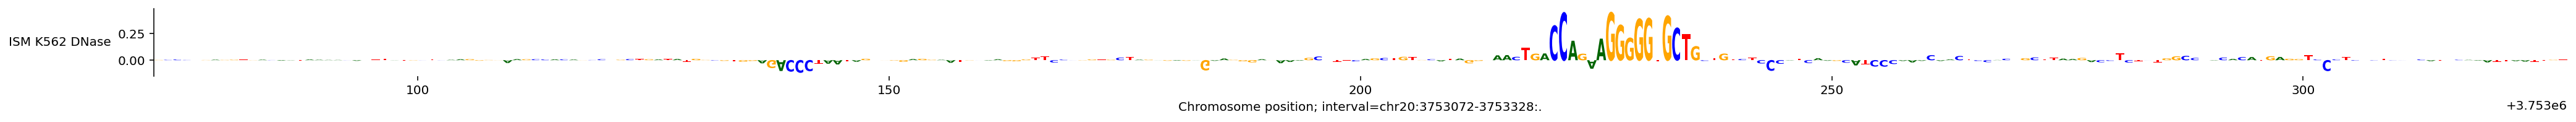

In [ ]:
plot_components.plot(
    [
        plot_components.SeqLogo(
            scores=ism_result,
            scores_interval=ism_interval,
            ylabel='ISM K562 DNase',
        )
    ],
    interval=ism_interval,
    fig_width=35,
)

plt.show()

This plot shows that the sequence between positions ~225 to ~240 has the strongest effect on predicted nearby DNAse in K562 cells.

These contribution scores can be used to systematically discover motifs important for different modalities and cell types, find the transcription factors binding those motifs and map motif instances across the genome. Here are a few tools you can use to do this:
- [tfmodisco-lite](https://github.com/jmschrei/tfmodisco-lite/)
- [tangermeme](https://github.com/jmschrei/tangermeme)
- [tomtom](https://meme-suite.org/meme/tools/tomtom)

## Making mouse predictions

So far, this notebook has focused on predictions for human (`Organism.HOMO_SAPIENS`). To generate predictions for mouse, specify the organism as `Organism.MUS_MUSCULUS` instead. Please note that the supported ontology terms differ between species.

The following example demonstrates how to call `predict_sequence` for mouse predictions:

In [ ]:
output = dna_model.predict_sequence(
    sequence='GATTACA'.center(2048, 'N'),  # Pad to valid sequence length.
    organism=dna_client.Organism.MUS_MUSCULUS,
    requested_outputs=[dna_client.OutputType.DNASE],
    ontology_terms=['UBERON:0002048'],  # Lung.
)

And here is an example of calling `predict_interval` for a mouse genomic interval:

In [ ]:
interval = genome.Interval('chr1', 3_000_000, 3_000_001).resize(
    dna_client.SEQUENCE_LENGTH_1MB
)

output = dna_model.predict_interval(
    interval=interval,
    organism=dna_client.Organism.MUS_MUSCULUS,
    requested_outputs=[dna_client.OutputType.RNA_SEQ],
    ontology_terms=['UBERON:0002048'],  # Lung.
)

output.rna_seq.values.shape

(1048576, 3)

## Conclusion

That's it for the quick start guide. To dive in further, check out our [other tutorials](https://www.alphagenomedocs.com/tutorials/index.html).
